In [1]:
import sys
sys.path.append("..")

from plotting_tools import *

In [2]:
def load_prevalence_data(result_file, num_age_groups):
    df = pd.read_csv(result_file, sep=',')
    unique_sims = df['Sim'].unique()
    unique_t = df['t'].unique()
    num_sims = len(unique_sims)
    num_timesteps = len(unique_t)
    # Create a mapping from Sim to index (0-based row in matrix)
    sim_to_idx = {sim: idx for idx, sim in enumerate(unique_sims)}
    infection_matrices = {
        f'rel_infected_ag_{ag}': np.zeros((num_sims, num_timesteps))
        for ag in range(num_age_groups)
    }
    
    # Index the DataFrame for faster access
    df.set_index(['Sim', 't'], inplace=True)

    # Fill matrices
    for (sim, t), row in df.iterrows():
        sim_idx = sim_to_idx[sim]
        t_idx = int(t)

        for ag in range(num_age_groups):
            num_inf = row[f'NumInfectedAg{ag}']
            num_agents = row[f'NumAgentsAg{ag}']
            if num_agents > 0:
                infection_matrices[f'rel_infected_ag_{ag}'][sim_idx, t_idx] = num_inf / num_agents
                
    return num_timesteps, infection_matrices

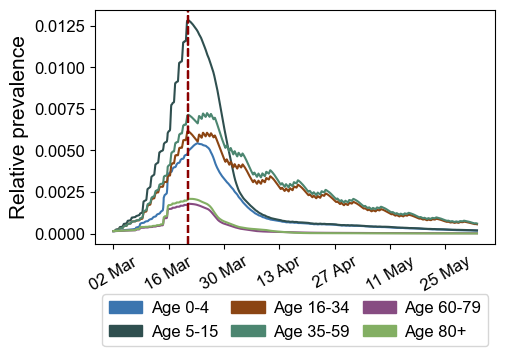

In [ ]:
num_age_groups = 6
result_file = 'num_agents_infections_hh_size_ag.txt'
num_timesteps, prevalence_matrices = load_prevalence_data(result_file, num_age_groups)
# Plot relative infected per age group         
fig = plt.figure(figsize=(5, 3.5))
ax = fig.add_axes([0.18, 0.31, 0.8, 0.67])
legend = {}
for ag in range(num_age_groups):
    label = f'Age {idx_to_age_group[ag]}'
    legend[label] = list(ag_to_color_dict.values())[ag]
    matrix = prevalence_matrices[f'rel_infected_ag_{ag}']
    # Means
    mean_vals = matrix.mean(axis=0)
    x = np.arange(num_timesteps)
    ax.plot(x, mean_vals, color=list(ag_to_color_dict.values())[ag], label=label)
    # Lockdown is at day 19
    t_lockdown = 24 * 19
    ax.axvline(x=t_lockdown, color=colors['Dark red'], linestyle='--')
    # x-ticks positions
    xticks = np.arange(0, num_timesteps, 14*24)
    ax.set_xticks(xticks)
    # Convert xlabels to dates starting from March 2
    start_date = datetime(2020, 3, 2)
    labels = [(start_date + timedelta(hours=int(i))).strftime('%d %b') for i in xticks]
    # Set the labels
    ax.set_xticklabels(labels, rotation=30)
    ax.set_ylabel('Relative prevalence')
    
#Legend
patchList = []
for key in legend:
    data_key = patches.Patch(color=legend[key], label=key)
    patchList.append(data_key)
ax.legend(handles=patchList, loc='lower center', bbox_to_anchor=(0.5, -0.47), ncol = 3, columnspacing=0.8, handletextpad=0.5)
fig.savefig(f'prevalence_per_ag.png', dpi=dpi)
plt.show()